Code adapted from https://github.com/yfletberliac/rlss-2019 (Practical Sessions of RLSS 2019: Bandits, RL & Deep RL. https://rlss.inria.fr/program/)

In [131]:
import numpy as np
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split as split
import matplotlib.pyplot as plt

# 1. Multi-Armed Bandit Problems
We study the classical multi-armed bandit problem specified by a set of real-valued
distributions $ (\nu_a)_{a \in \mathcal{A}}$ with means $(\mu_a)_{a \in \mathcal{A}} \in \mathbb{R}^\mathcal{A}$, where $\mathcal{A}$ is a finite set of arms.
## 1.1 Bandit Arms

In [132]:
# A generic bandit arm class has one
# method to sample a reward from a probability distribution

class Arm:
    def __init__(self, mean: float):
        self.mean = mean
        pass
    def sample_reward(self):
        raise NotImplementedError

# For example, a Bernoulli bandit arm looks like this
class BernoulliArm(Arm):
    def __init__(self, p:float):
        # create a Bernoulli arm with mean p
        super().__init__(mean=p)

    def sample(self):
        # generate a reward from a Bernoulli arm
        return np.random.random() < self.mean

class ExponentialArm(Arm):
    def __init__(self, beta:float):
        super().__init__(mean=beta)

    def sample(self):
        return np.random.exponential(scale=self.mean)

## 1.2 Exercise 1: Implement a bandit arm class with Gaussian distribution.

In [133]:
class GaussianArm(Arm):
    def __init__(self, mean: float, var: float):
        super().__init__(mean=mean)
        self.var = var

    def sample(self):
        return np.random.normal(loc=self.mean, scale=np.sqrt(self.var))

## 1.3 A Multi-Armed Bandit (MAB).

In [134]:
# We now write a generic MAB problem.
# When pulling arm K of a bandit problem, a learning agent gets an instantinuous
# reward and a regret value that is the difference between this reward and the best
# mean over all arms.

class MAB:
    def __init__(self, arms: list[Arm]):
        self.arms = arms
        # We compute the max over arms means for regret computations
        self.best_arm_mean = max([arm.mean for arm in self.arms])

    def sample(self, arm_number: int):
        reward = self.arms[arm_number].sample()
        regret = self.best_arm_mean - reward
        return reward, regret

# A bandit problem with two exponential arms and one Bernoulli arm
test_mab = MAB([ExponentialArm(beta=0.3), ExponentialArm(beta=0.1), BernoulliArm(p=0.7)])
reward, regret = test_mab.sample(arm_number=0)

## 1.4 Exercise 2: Implement a simple MAB class where all the arms are Bernoulli distributed. Instantiate this class by passing a list of means.

In [135]:
class MABBernoulli(MAB):
    def __init__(self, list_means: list[float]):
        list_arms = []
        for mean in list_means:
            list_arms.append(BernoulliArm(p=mean))
        super().__init__(arms=list_arms)
        #super().__init__([BernoulliArm(mean) for mean in list_means])

## 1.5 Cumultative Regret Minimization
At each time $t \geq 1$, a learner must choose an arm $a_t \in \mathcal{A}$, based only on
the past. The learner then receives and observes a reward $X_t$ sampled according to $\nu_{a_t}$. The goal of the learner is simply to maximize the expected sum of rewards received over time, or equivalently minimize regret
with respect to the strategy constantly receiving the highest mean reward.

In [136]:
# Bandit algorithms learn arm pulling strategies to minimize the cumulative regret over T pulls.
def cumul_regret(regrets: list[float]):
    return np.cumsum(regrets)

# 2. Bandit Algorithms
## 2.1 Uniform Sampling

In [137]:
# A bandit algorithm has one key component which is the sampling strategy (which arm to pull ater T pulls).

class BanditAlgo:
    def __init__(self, mab: MAB):
        self.mab = mab
        self.rewards = []
        self.regrets = []
        self.arms_drawn = []

    def sampling(self, timesteps_T: int):
        # Where to implement the sampling strategies
        raise NotImplementedError

# The most naive bandit algorithm is to draw arms at random.
class UniformSamplingAlgo(BanditAlgo):
    def __init__(self, mab: MAB):
        super().__init__(mab=mab)

    def sampling(self, timesteps_T: int):
        for i in range(timesteps_T):
            arm_to_pull = np.random.randint(0, len(self.mab.arms))
            reward, regret = self.mab.sample(arm_to_pull)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(arm_to_pull)

## 2.2 Naive algorithms: Follow the Leader (FTL) and Explore then Commit (ETC)

In [138]:
# Other naive algorithms include Follow the Leader and Explore then Commit. They
# both sample each arm at least once before pulling the best arm for the rest of
# the time.
class FollowTheLeader(BanditAlgo):
    def __init__(self, mab: MAB):
        super().__init__(mab=mab)

    def sampling(self, timesteps_T: int):
        if len(self.mab.arms) > timesteps_T:
            print("Warning: more arms than timesteps")

        # Pull each arm once
        for i in range(len(self.mab.arms)):
            reward, regret = self.mab.sample(i)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(i)

        # Get the best arm
        best_arm_pull = np.argmax(self.rewards)
        best_arm = self.arms_drawn[best_arm_pull]

        # for the rest of the time, pull the best arm
        for j in range(len(self.mab.arms), timesteps_T):
            reward, regret = self.mab.sample(best_arm)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(best_arm)

class ExploreThenCommit(BanditAlgo):
    def __init__(self, mab: MAB, explore_fraction: float):
        super().__init__(mab=mab)
        self.explore_fraction = explore_fraction

    def sampling(self, timesteps_T: int):
        explore_steps = int(timesteps_T * self.explore_fraction)
        for i in range(explore_steps):
            arm_to_pull = np.random.randint(0, len(self.mab.arms))
            reward, regret = self.mab.sample(arm_to_pull)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(arm_to_pull)

        # Get the best arm
        best_arm_pull = np.argmax(self.rewards)
        best_arm = self.arms_drawn[best_arm_pull]

        # for the rest of the time, pull the best arm
        for j in range(explore_steps, timesteps_T):
            reward, regret = self.mab.sample(best_arm)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(best_arm)

In [139]:
# A plotting function
def plot_mean_std_cumul_regret(regret_matrix: list[list[float]], algo_name: str):
    means = regret_matrix.mean(axis=0)
    stds = regret_matrix.std(axis=0)
    plt.plot(means, label=algo_name)
    plt.fill_between(np.arange(len(means)), means - stds, means + stds, alpha = 0.1)


Text(0, 0.5, 'Cumulative Regret')

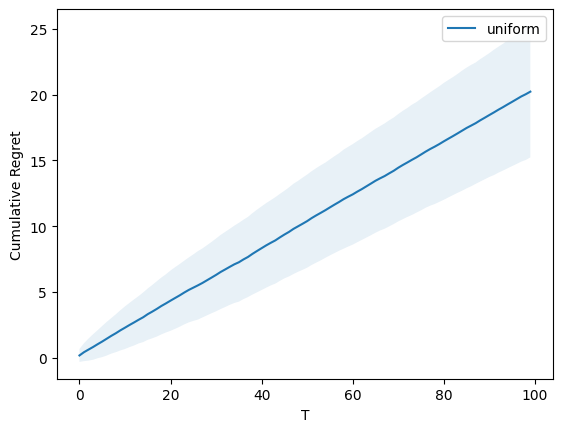

In [140]:
# Example of Uniform Sampling algo on a two-armed Bernoulli bandit

# MAB problem
mab = MAB([BernoulliArm(p=0.2), BernoulliArm(p=0.6)])
# Experimental Setup
repetitions = 1000
timesteps_per_repet = 100
cum_regrets = np.zeros((repetitions, timesteps_per_repet))

for rep in range(repetitions):
    unif = UniformSamplingAlgo(mab)
    unif.sampling(timesteps_per_repet)
    cum_regrets[rep] = cumul_regret(unif.regrets)
plot_mean_std_cumul_regret(cum_regrets, 'uniform')
plt.legend()
plt.xlabel("T")
plt.ylabel("Cumulative Regret")

## 2.3 Exercise 3: Plot the cumulative regret of bandit algorithms Uniform, FTL, and ETC on a Bernoulli MAB problem. Try different exploration rates for ETC.
Try different MAB Problems (try one with gaussian arms, that have high variance).

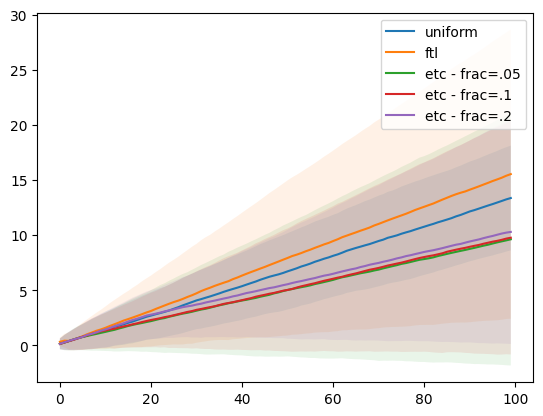

In [141]:
# MAB problem
mab = MAB([BernoulliArm(p=0.2), BernoulliArm(p=0.4), BernoulliArm(p=0.5)])
# Experimental Setup
repetitions = 1000
timesteps_per_repet = 100
cum_regrets_uni = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_ftl = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_5 = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_10 = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_20 = np.zeros((repetitions, timesteps_per_repet))

for rep in range(repetitions):
    unif = UniformSamplingAlgo(mab)
    unif.sampling(timesteps_per_repet)
    cum_regrets_uni[rep] = cumul_regret(unif.regrets)

    ftl = FollowTheLeader(mab)
    ftl.sampling(timesteps_per_repet)
    cum_regrets_ftl[rep] = cumul_regret(ftl.regrets)

    etc5 = ExploreThenCommit(mab, .05)
    etc5.sampling(timesteps_per_repet)
    cum_regrets_etc_5[rep] = cumul_regret(etc5.regrets)

    etc10 = ExploreThenCommit(mab, 0.1)
    etc10.sampling(timesteps_per_repet)
    cum_regrets_etc_10[rep] = cumul_regret(etc10.regrets)

    etc20 = ExploreThenCommit(mab, 0.2)
    etc20.sampling(timesteps_per_repet)
    cum_regrets_etc_20[rep] = cumul_regret(etc20.regrets)

plot_mean_std_cumul_regret(cum_regrets_uni, 'uniform')
plot_mean_std_cumul_regret(cum_regrets_ftl, 'ftl')
plot_mean_std_cumul_regret(cum_regrets_etc_5, 'etc - frac=.05')
plot_mean_std_cumul_regret(cum_regrets_etc_10, 'etc - frac=.1')
plot_mean_std_cumul_regret(cum_regrets_etc_20, 'etc - frac=.2')
plt.legend()

In [142]:
def simulate(mab, algo, timesteps_per_repet, repetitions, **kwargs):
    cum_regrets = np.zeros((repetitions, timesteps_per_repet))
    for rep in range(repetitions):
        exp = algo(mab, **kwargs)
        exp.sampling(timesteps_per_repet)
        cum_regrets[rep] = cumul_regret(exp.regrets)
    return cum_regrets

In [143]:
# MAB problem
mab = MAB([GaussianArm(mean=0., var=2.),
           GaussianArm(mean=1., var=.5),
           BernoulliArm(p=.5)])
# Experimental Setup
repetitions = 1000
timesteps_per_repet = 100

In [144]:
uni_cum_regrets = simulate(mab, UniformSamplingAlgo, timesteps_per_repet, repetitions)
ftc_cum_regrets = simulate(mab, FollowTheLeader, timesteps_per_repet, repetitions)
etc_cum_regrets1 = simulate(mab, ExploreThenCommit, timesteps_per_repet, repetitions, explore_fraction=0.1)
etc_cum_regrets2 = simulate(mab, ExploreThenCommit, timesteps_per_repet, repetitions, explore_fraction=0.5)

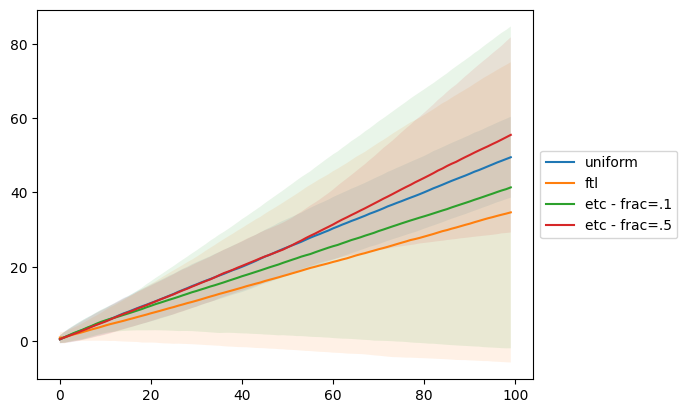

In [145]:
plot_mean_std_cumul_regret(uni_cum_regrets, 'uniform')
plot_mean_std_cumul_regret(ftc_cum_regrets, 'ftl')
plot_mean_std_cumul_regret(etc_cum_regrets1, 'etc - frac=.1')
plot_mean_std_cumul_regret(etc_cum_regrets2, 'etc - frac=.5')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

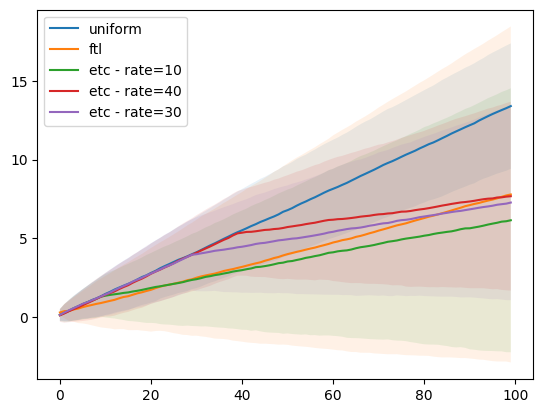

In [146]:
# MAB problem
mab = MAB([ExponentialArm(beta=0.2), ExponentialArm(beta=0.4), ExponentialArm(beta=0.5)])
# Experimental Setup
repetitions = 1000
timesteps_per_repet = 100
cum_regrets_uni = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_ftl = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_5 = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_10 = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_20 = np.zeros((repetitions, timesteps_per_repet))

for rep in range(repetitions):
    unif = UniformSamplingAlgo(mab)
    unif.sampling(timesteps_per_repet)
    cum_regrets_uni[rep] = cumul_regret(unif.regrets)

    ftl = FollowTheLeader(mab)
    ftl.sampling(timesteps_per_repet)
    cum_regrets_ftl[rep] = cumul_regret(ftl.regrets)

    etc5 = ExploreThenCommit(mab, 0.1)
    etc5.sampling(timesteps_per_repet)
    cum_regrets_etc_5[rep] = cumul_regret(etc5.regrets)

    etc10 = ExploreThenCommit(mab, 0.4)
    etc10.sampling(timesteps_per_repet)
    cum_regrets_etc_10[rep] = cumul_regret(etc10.regrets)

    etc20 = ExploreThenCommit(mab, 0.3)
    etc20.sampling(timesteps_per_repet)
    cum_regrets_etc_20[rep] = cumul_regret(etc20.regrets)

plot_mean_std_cumul_regret(cum_regrets_uni, 'uniform')
plot_mean_std_cumul_regret(cum_regrets_ftl, 'ftl')
plot_mean_std_cumul_regret(cum_regrets_etc_5, 'etc - rate=10')
plot_mean_std_cumul_regret(cum_regrets_etc_10, 'etc - rate=40')
plot_mean_std_cumul_regret(cum_regrets_etc_20, 'etc - rate=30')
plt.legend()

# 3. Advanced Bandit Algorithms

## 3.1 Exercise 4: Implement the Upper Confidence Bound algorithm [UCB](https://fr.wikipedia.org/wiki/Algorithme_UCB)
For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the Upper Confidence Bound is defined as foollows:
$$ U_a(t) = \hat\mu_a(t)+ \sqrt{\frac{\log\!\left(1/\delta_t\right)}{2N_a(t)}} \,, $$
with $ \delta_t=t^{-2}(t+1)^{-1}$.


UCB is the strategy that consists in pulling an arm with maximal upper confidence bound at each time step:
$$ a_{t+1} = \arg\!\max_{a \in \mathcal{A}}U_a(t)  \,.$$

In [147]:
class UpperConfBounds(BanditAlgo):
    def __init__(self, mab: MAB, alpha: float=0.5):
        super().__init__(mab=mab)
        self.alpha = alpha
        self.Qs = [[] for arm in self.mab.arms] # list of rewards for each arm a
        self.Ns = [0 for arm in self.mab.arms] #nb of times each arm is pulled

    def sampling(self, timesteps_T: int):
        for i in range(timesteps_T): #Here we only explore each arm once, we could however explore just like in etc
            if i < len(self.mab.arms):
                arm_to_pull = i
                self.Ns[arm_to_pull] +=  1
                reward, regret = self.mab.sample(arm_to_pull)
                self.Qs[arm_to_pull].append(reward)
                self.rewards.append(reward)
                self.regrets.append(regret)
                self.arms_drawn.append(arm_to_pull)
            else:
                # print(self.Qs, self.Ns)
                Ua_t = [sum(x) for x in zip([np.sqrt(np.log(((i**2)*(i+1)))/ 2 * x) for x in self.Ns], [np.mean(q) for q in self.Qs])]
                # print(Ua_t)
                arm_to_pull = np.argmax(Ua_t)
                self.Ns[arm_to_pull] +=  1
                reward, regret = self.mab.sample(arm_to_pull)
                self.Qs[arm_to_pull].append(reward)
                self.rewards.append(reward)
                self.regrets.append(regret)
                self.arms_drawn.append(arm_to_pull)

## 3.2 Exercise 5: Implement the Thompson Sampling algorithm [TS](https://) with Beta prior and Bernoulli likelihood
For all arm $a \in \mathcal{A}$, for all time step  $t \geq 1$, the cumulative reward from arm $a$ at time $t$ is $$S_a(t) = \sum\limits_{s = 1}^t \mathbb{1}_{\{a_s = a\}}X_s\,, $$
and the number of pulls of arm $a$ at time $t$ is
$$N_a(t) = \sum\limits_{ s=1}^t \mathbb{1}_{\{ a_s = a\}} \,.$$

In a Bayesian view on the MAB, the $(\mu_a)_{a\in\mathcal{A}}$ are no longer seen as unknown parameters but as (independent)random variables following a uniform distribution. The posterior distribution on the arm $a$ at time $t$ of the bandit game is the distribution of $\mu_a$ conditional to the observations from arm $a$ gathered up to
time $t$ and it is denoted $\pi_a(t)$ . Each sample from arm $a$ leads to an update of this posterior distribution.


TS is the strategy that consists in drawing $\theta_a(t)\sim \pi_a(t)=Beta(N_a(t) + 1, N_a(t) - S_a(t) + 1)$ at time step t and for each arm $a$, then pulling the arm:
$$ a_{t+1} = \arg\!\max_{a \in \mathcal{A}}\theta_a(t)  \,.$$

In [148]:
class ThompsonSampling(BanditAlgo):
    def __init__(self, mab: MAB, a: int=1, b: int=1):
        super().__init__(mab=mab)
        self.a = a
        self.b = b

    def sampling(self, timesteps_T: int):
        # TODO
        pass

# **Graded Home Assignment 1. Contextual Bandits.**
## 1. Learning a classifier with contextual bandits.
A supervised classification problem $(X,y)$ with $X$ the dataset features in $\mathbb{R}^{N \times d}$ and $y$ the classes vector in $\{1,...,K\}^N$ can be formulated as a [contextual bandits problem](https://tor-lattimore.com/downloads/book/book.pdf) formalized as follows. At time $t$ a learner observes a context vector $x_n$ drawn at random from $X$. The learner then pulls an arm $a \in A = \{1, ..., K\}$ based on $x_n$ and receives a binary reward $\mathbb{1}_{\{a=y_n\}}$. Learning a function $f:X\rightarrow A$ that maximizes the expected cumulative reward $\mathbb{E}_{x_n \sim X}[∑_{t=0}^T \mathbb{1}_{\{f(x_n)=y_n\}}]$ is learning a classifier that minimizes the misclassficiation rate.

For reference, see sections 5.1 and following of this [scientific article](https://arxiv.org/abs/1103.4601).

In [149]:
# Note that a contextual bandits arm conditioned on the probability of observing
# a given context returns either 0 or 1. The arm could also be defined
# independently of the context and in that case it is a Bernoulli which mean is
# the proportion of data in class k.
class ClassLabelArm:
    def __init__(self, label:int):
        self.label = label

    def sample_reward(self, predicted_label:int):
        return self.label == predicted_label

In [150]:
class SupervisedLearningAsBandits:
    def __init__(self, X:list[list[float]], y:list[int]):
        self.arms = [ClassLabelArm(k) for k in set(y)]
        self.current_context = None
        self._current_true_label = None

    def get_context(self):
        rdm_context_idx = np.random.choice(np.arange(len(X)))
        self.current_context = X[rdm_context_idx]
        self._current_true_label = y[rdm_context_idx]
        return self.current_context

    def sample(self, arm_number:int):
        reward = self.arms[arm_number].sample_reward(self._current_true_label)
        regret = 1 - reward
        return reward, regret


## 2. Contextual bandits algorithms.
We now provide a base class for a learning algorithms that pulls arm depending on the observed context. Similarly to classical multi-armed bandits, one can define a Uniform Sampler that pulls arms indenpendently of the context. The counterpart of this random algorithms is a learner (that is not one) that stores in memory all the observed context and the associated true class label. Note that the later algorithm is memory ineficient and cannot generalize to unseen data. Furthermore, a learner must not observe the true class label when an arm is pulled, but only th 0-1 reward. The memory based bandits algorithm is provided as an overpowered baseline.

In [151]:
class ContextualBanditsAlgo:
    def __init__(self, contextual_bandits:SupervisedLearningAsBandits):
        self.mab = contextual_bandits
        self.rewards = []
        self.regrets = []
        self.arms_drawn = []

    def arm_to_pull(self, context:list[float]):
        raise NotImplementedError

    def sampling(self, timesteps_T:int):
        raise NotImplementedError

class UniformSamplingForCB(ContextualBanditsAlgo):
    def __init__(self, contextual_bandits:SupervisedLearningAsBandits):
        super().__init__(contextual_bandits)

    def arm_to_pull(self, context:list[float]):
        return np.random.randint(len(self.mab.arms))

    def sampling(self, timesteps_T:int):
        for t in range(timesteps_T):
            ctxt = self.mab.get_context()
            arm_to_pull = self.arm_to_pull(ctxt)
            reward, regret = self.mab.sample(arm_to_pull)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(arm_to_pull)

class ContextMemory(ContextualBanditsAlgo):
    def __init__(self, contextual_bandits:SupervisedLearningAsBandits):
        super().__init__(contextual_bandits)
        self.memory = dict()

    def arm_to_pull(self, context:list[float]):
        if tuple(context) not in self.memory.keys():
            return np.random.randint(len(self.mab.arms))
        else:
            return self.memory[tuple(context)]


    def sampling(self, timesteps_T:int):
        for t in range(timesteps_T):
            ctxt = self.mab.get_context()
            arm_to_pull = self.arm_to_pull(ctxt)
            reward, regret = self.mab.sample(arm_to_pull)
            ##### YOU SHOULD NOT ACCESS THE TRUE LABEL ######
            self.memory[tuple(ctxt)] = self.mab._current_true_label
            #################################################
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(arm_to_pull)

## 3. An experimental setup.
The goal of the homework is for you to design a contextual bandits algorithm that achieves cumulative reward close to the memory-based algorithm on the breast cancer classification dataset.
- The final mark is based on a 3 pages report of your experiments and algorithmic design choices.
- Justify the design choices by adding references to research articles.
- Justify the design choices by adding cumulative rewards curves.
- You can try whatever you want but keep a critical mind by looking at the memory usage of your algorithm as well as runtimes: high cumulative reward is not everything.
- Look at the train/test misclassifications of your algorithms after learning.
- When you are done, send your report as .pdf to hector.kohler@inria.fr


Text(0, 0.5, 'Cumulative Reward')

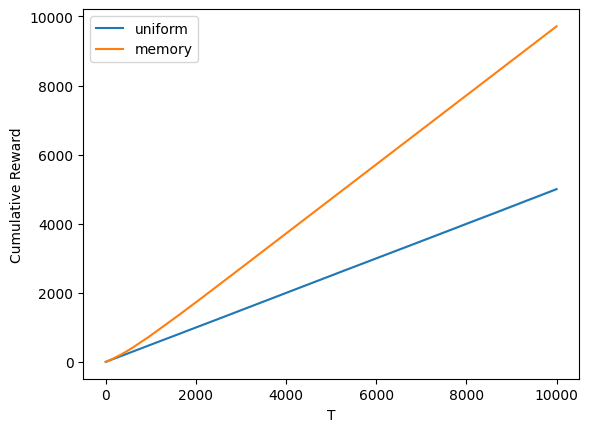

In [127]:
X, y = datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = split(X, y, test_size=0.25, random_state=42)
contextual_bandits = SupervisedLearningAsBandits(X_train, y_train)
repetitions = 100
timesteps_per_repet = 10000

cum_rewards = np.zeros((repetitions, timesteps_per_repet))
for repets in range(repetitions):
    ctxt_bandit_algo_random = UniformSamplingForCB(contextual_bandits)
    ctxt_bandit_algo_random.sampling(timesteps_per_repet)
    cum_rewards[repets] = cumul_regret(ctxt_bandit_algo_random.rewards)

plot_mean_std_cumul_regret(cum_rewards, 'uniform')

cum_rewards = np.zeros((repetitions, timesteps_per_repet))
for repets in range(repetitions):
    ctxt_bandit_algo_memory = ContextMemory(contextual_bandits)
    ctxt_bandit_algo_memory.sampling(timesteps_per_repet)
    cum_rewards[repets] = cumul_regret(ctxt_bandit_algo_memory.rewards)

plot_mean_std_cumul_regret(cum_rewards, 'memory')
plt.legend()
plt.xlabel("T")
plt.ylabel("Cumulative Reward")

In [128]:
def get_misclassif(X, y, contextual_bandit_algo):
    misclassif = 0
    for x_n, y_n in zip(X,y):
        arm = contextual_bandit_algo.arm_to_pull(x_n)
        is_misclassif = contextual_bandit_algo.mab.arms[arm].label != y_n
        # can also do this !contextual_bandit_algo.mab.arms[arm].sample_reward(y_n)
        misclassif += is_misclassif
    return misclassif/len(X) * 100

In [129]:
print("The test misclassif rate after learning of the contextual bandits algorithm {} is: {} %".format("random", get_misclassif(X_test,y_test, ctxt_bandit_algo_random)))
print("The test misclassif rate after learning of the contextual bandits algorithm {} is: {} %".format("Memory-based", get_misclassif(X_test,y_test, ctxt_bandit_algo_memory)))

The test misclassif rate after learning of the contextual bandits algorithm random is: 52.44755244755245 %
The test misclassif rate after learning of the contextual bandits algorithm Memory-based is: 0.0 %


In [130]:
print("The train misclassif rate after learning of the contextual bandits algorithm {} is: {} %".format("random", get_misclassif(X_train,y_train, ctxt_bandit_algo_random)))
print("The train misclassif rate after learning of the contextual bandits algorithm {} is: {} %".format("Memory-based", get_misclassif(X_train,y_train, ctxt_bandit_algo_memory)))

The train misclassif rate after learning of the contextual bandits algorithm random is: 51.87793427230047 %
The train misclassif rate after learning of the contextual bandits algorithm Memory-based is: 0.0 %
